# Decision curve analysis or why interpretation of medical statistical models should be based on their potential medical benefit
*Where we explore why decision curve analysis is very powerful for medical models*

# Introduction
A key property of any medical decision (support) model is their performance: how good they are at their job. A natural choice would be how often the model returns the correct answer, i.e. the accuracy. However, in medical datasets the number of sick people is often much smaller than the number of healthy people. Therefore, a model that states no one is sick can have a very high accuracy (0.9 if 90% of people is healthy). If the goal of the model is to find sick people because they need treatment, this 0.9 accuracy is not meaningful at all.  

So choosing the correct meaure of performance (metric) that matches the underlying goal we have with the the model is vital. The goal of this article is to introduce a particularly useful metric in a medical context, net benefit (TODO: cite papers), that allows a close analogue between the metric and medical pactice. To provide context we also explore two common other metrics: accuracy and AUC. We explore their underlying concepts, and see how they are extended in net benefit. But first we start by introducing the case study that we use to illustrate all of the metrics.

# Our case study
Prostate cancer is a very prevalent disease, which is much more treatable if detected early. Elevated PSA levels in the patients blood indicate that something might be wrong, but the definitive way to determine prostate cancer is to collect a tissue sample via a biopsy. However, the biopsy itself is not without risks so we are faced with a number of alternatives:

- Biopsy all patients, ensuring we do not miss any prostate cancer, at the cost of many unnecessary biopsies
- Biopsy no one, ensuring no unecessary biopsies, at the cost of missing all patients with prostate cancer
- A statistical model that determines whom of the patients we should biopsy or not based on patient characteristics. 

Intuitively, the statistical model feels like the best option, but the biopsy-all and biopsy-no-one provide context for the model. The model uses the age of the patient (`age`), a genetic marker (`marker`) and wether or not there is a family history of cancer (`famhistory`) to predict if the patient has cancer or not (`cancer`). If the model judges it likely that the patient has cancer, we perform a biopsy. The following code creates a logistic regression model, and shows the fitted coefficients: 

In [31]:
import pandas as pd
import statsmodels.api as sm
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')

biopsy_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()
print(biopsy_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.89
Date:                Wed, 03 Apr 2024   Deviance:                       427.79
Time:                        09:45:57   Pearson chi2:                     743.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.0703      2.211     -9.984      0.0

For this kind of logistical regression model we can take the exponent of the model parameters to get some nicely interpretable coefficients:

In [32]:
np.exp(biopsy_model.params)

Intercept     2.600116e-10
age           1.325770e+00
marker        2.660012e+00
famhistory    2.375435e+00
dtype: float64

All these coefficients represent odds ($\frac{p}{1-p}$) of a patient having cancer:

- `intercept` For a patient with the hypotheical age 0, zero score on the marker and no family history of cancer the odds are almost zero that a patient has cancer.
- `age` for each year the patient is older, the odds of cancer become 1.3 times bigger. 
- `marker` for each unit increase of the marker, the odds of cancer become 2.7 times bigger.
- `famhistory` a family history of cancer increases the likelihood of cancer 2.4 times. 

Note that the model returns the probability a patient has cancer, to get a biopsy/no-biopsy decision we need to choose above which probablity of cancer we order a biopsy. This is called the probability threshold, and the process of choosing the threshold is called *model calibration*. If, for example, we choose a threshold of 0.2 we deem a biopsy to be necessary when the risk of cancer is 20% or higher. Using a higher threshold in this case seems unrealistic, any patient that is told that their chance of cancer is 1 in 5 (odds 1:4) would want to have a biopsy to be sure. 

Note that the `P>|z|` values of the coefficients are well below 0.025, so this models seems to have predictive power and would be promising to base our biopsy/no-biopsy decision on. This is further confirmed if we draw a scatterplot including the decision boundary of probability threshold 0.2 and patients with a history of cancer in the family:

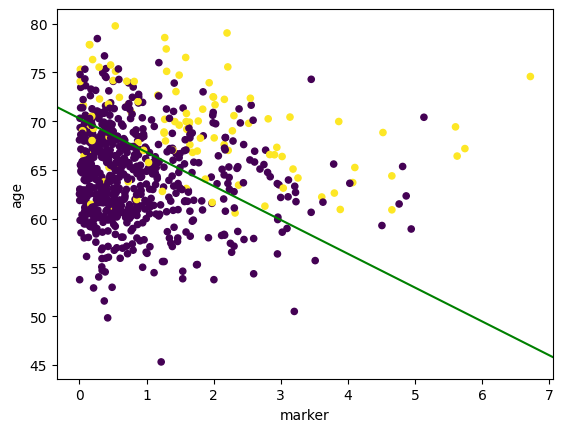

In [33]:
import matplotlib.pyplot as plt

p_thold = 0.2
logit_p = np.log(p_thold / (1 - p_thold))

marker_range = np.linspace(*df_cancer_dx['marker'].agg(['min', 'max']))
ax = df_cancer_dx[['cancer', 'marker', 'age']].plot(kind='scatter', x='marker', y='age', c='cancer', colormap='viridis', colorbar=False)

c_intercept, c_age, c_marker, c_famhistory = biopsy_model.params
marker_range = df_cancer_dx['marker'].agg(['min', 'max'])

famhistory = 1
age_pred = (-c_intercept - c_marker * marker_range - c_famhistory * famhistory + logit_p) / c_age
ax.axline((marker_range[0], age_pred[0]), (marker_range[1], age_pred[1]), color='green', label='famhistory')   

where the yellow dots are the actual recorded cancer patients, and the model judges everyone above the green line to need a biopsy. We see that the cancer patients (yellow dots) are mostly situated in the 'high-marker/high-age' quadrant of the plot, but some patients that have cancer are not given a biopsy and vice versa. So, the model has predictive power, but is certainly not flawless in deciding who should get a biopsy or not. 

# The building blocks of model evaluation
The building blocks of our metrics are how often the model makes the correct or wrong decision. In the plot above, we have patients with cancer that are not given a biopsy (yellow dots under the line). This is called a False Negative (FN) as we falsely assume that no biopsy is needed. The inverse of that is the False Positive (purple dots above the green line), where based on the model we falsely assume that a biopsy is needed. The model also makes good decisions, in this case True Positives (TP, correctly assign biopsy) and True Negatives (TN, correctly omit biopsy). TP, TN, FP and FN form the basis for all of the metrics we discuss in this article. 

# The most basic metric: accuracy
For many machine learning applications, accuracy is the most obvious performance metric to use. This is simply defined as the fraction of times the model makes the correct decision:

$$
ACC = \frac{TP + TN}{n_{total} + n_{non-cancer}}
$$

The accuracy of our biopsy model is:

In [34]:
from sklearn.metrics import accuracy_score
thold = 0.2

accuracy_score(biopsy_model.predict(df_cancer_dx[['age', 'marker', 'famhistory']]) >= thold, df_cancer_dx['cancer'])

0.8293333333333334

Which shows that the model makes the correct decision 83% of the time when using a probability threshold of 0.2. For our two other treatment options (biopsy everyone, biopsy no one) we get the following accuracies:

In [35]:
# biopsy everyone
print(accuracy_score(np.ones(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))
#  biopsy no one
print(accuracy_score(np.zeros(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))

0.14
0.86


In [39]:
len(df_cancer_dx['cancer']) * 0.14

105.00000000000001

This is an unexpected result: our model seemed to have significant predictive power but the model accuracy is lower then simply giving no one a biopsy (83% versus 86%). This does not make sense, all the cancer patients in the dataset would not get a cancer diagnosis (14%, 105 patients) and suffer massive consequences. But why is accuracy such a poor metric in this case?

Looking at the accuracies for `biopsy-everyone` and `biopsy-no-one` provides a hint as to what is going on: the accuracies are the exact fractions of cancer and non-cancer patients in the dataset. In addition, the number of healthy patients is much larger or in statistical terms: the dataset is unbalanced. By comparing the number of TP+TN versus the *size of the entire dataset* the extremely simple `biopsy-no-one` model can have a very high accuracy. So the accuracy is far too strongly influenced by the imbalance in the dataset to provide a meaningful interpretation of the performance of our model compared to the `biopsy-everyone` and `biopsy-no-one` options. 

# A better metric: Area under curve (AUC)
So, how do we deal with unbalanced datasets? A trick that is often used is to not look at the fraction or rate of good decisions versus the entire dataset, but the fraction of good decisions *per prediction category* (cancer/non-cancer). The two key ones are the True Positive Rate (TPR) and the False Positive Rate (FPR):

- TPR, what fraction of the time does the model predict cancer *when the patient actually has cancer* ($TPR = \frac{TP}{n_{cancer}}$) and thus the biopsy was correctly performed. This is also known as the *sensitivity* of the model. 
- FPR, what fraction of the time does the model predict cancer when the patient actually *does **not** have cancer* ($FPR = \frac{FP}{n_{non-cancer}}$), and the the biopsy was unecessary. This is also know as one minus the *specificity* of the model. 

By separating the performance per category, the performance in detecting cancer (TPR) becomes obvious, whilst in the case of accuracy it was obscured by the massive amount of healthy people. 

As we stated earlier, to make cancer/non-cancer decisions we need to pick a decision threshold $\theta$. But how does $\theta$ influence the TPR and FPR? The following plot shows the distribution of probabilities of our biopsy model, with density lines for the cancer and non-cancer patients:

<Axes: title={'center': 'Density plot'}, ylabel='Density'>

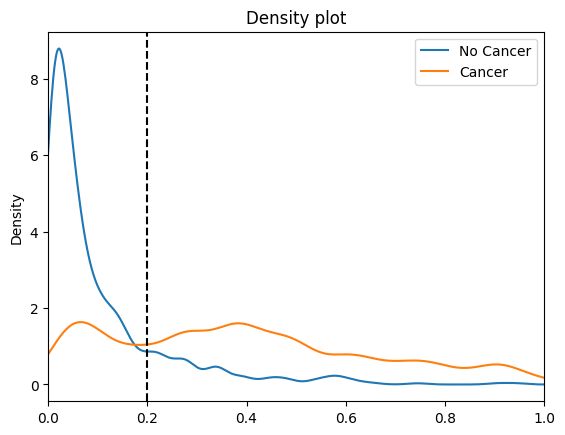

In [41]:
df_cancer_dx['biopsy_prob'] = biopsy_model.predict(df_cancer_dx)
df_cancer_dx['noone_prob'] = np.zeros(len(df_cancer_dx['cancer'])) 
df_cancer_dx['everyone_prob'] = np.ones(len(df_cancer_dx['cancer'])) 

prob_density_plot(df_cancer_dx, y='biopsy_prob', by='cancer', vline=[0.2])

Important to note here:

- Non-cancer patients overwhelmingly have a low predicted probability of cancer (blue line). Choosing a threshold probabilty of 0.2 means that the True Negative Rate or specificity will be very high. Because of that, the False Positive Rate (unecessary biopsies) will be quite low.
- Cancer patients show a much more broad range of predicted probabilities (orange line), which means that whichever probability threshold we choose the True Positive Rate (accurately assigned biopsies) will never be close to one. 

Here we see there is a tradeoff between the model accurately identifying cancer patients (TPR) and limiting unneeded biopsies (FPR). If we plot the TPR and FPR for different values of the $\theta$ we get a so called Relative Operating Characteristic (ROC) curve. The next figure shows the ROC curves for our three treatment options:

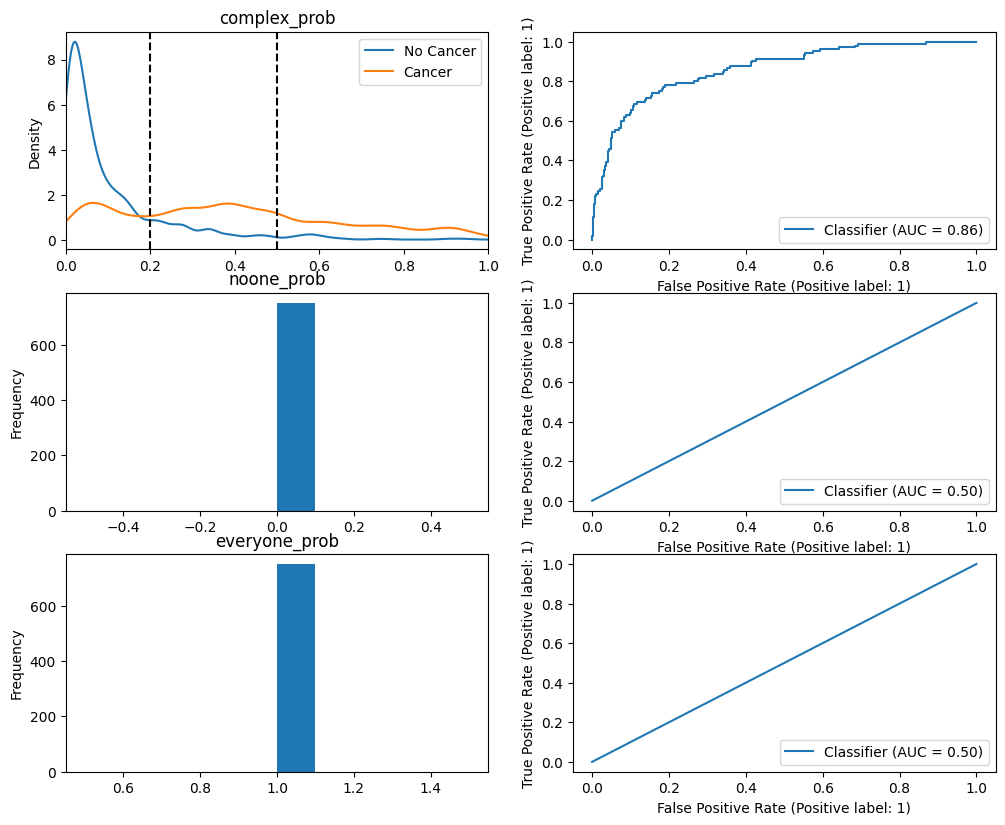

In [19]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(12,13))
base_subplot = 420

for i, col in enumerate(['complex_prob', 'noone_prob', 'everyone_prob']):
    roc_pos_offset = (2*(i + 1))
    plt.subplot(base_subplot + roc_pos_offset - 1)
    if col == 'complex_prob':
        prob_density_plot(df_cancer_dx, col, 'cancer', title=col)
    elif col == 'famhistory_prob':
        df_cancer_dx.groupby('cancer')[col].plot.hist(legend=True, xlim=(0,1), title=col)
    else:
        df_cancer_dx[col].plot(kind='hist', title=col)

    ax = plt.subplot(base_subplot + roc_pos_offset)
    RocCurveDisplay.from_predictions(y_true = df_cancer_dx['cancer'], y_pred = df_cancer_dx[col], ax=ax)

The plots also shows a so called AUC score, this is the area under the ROC curve. The AUC quanitfies the performance of the model over the whole range of possible probability tresholds. The lowest value for the AUC is 0.5, which means that the classifier is no better than randomly guessing which patient needs a biopsy or not. Important to note in the figure:

- The ROC curves for the 'biopsy-no-one' and 'biopsy-everyone' show a flat line and an AUC of 0.5. For example for 'biopsy-everyone', all probabilites for all patients are 1. So the TPR for any probability threshold is 1 as all cancer patients are given a biopsy, but the FPR is also 1 as every non-cancer patient also are given a biopsy. The AUC is 0.5, so the 'biopsy-everyone' is no better then randomly choosing whom to biopsy. 
- The ROC curve for the complex model is a lot better, showing the model to be significantly better than randomly assigning biopsies. 

So the AUC is a much better metric that is not sensitive to unbalanced data, and this makes it very suitable for evaluating medical models. But there is still one problem: for the AUC a detected cancer patient and an unecessary biopsy are of the same importance. That makes no sense: missing a cancer patient and having them die is obviously more harmful then an unecessary biopsy. Next we will look at a metric which address that shortcoming: the net benefit metric from decision curve analysis. 

# An ever better metric: net benefit
Decision curve analysis introduces a new metric called the net benefit. It frames the performance of the model as a cost-benefit analysis. The net benefit nicely builds up from our previous two metrics. 

### Accuracy cost-benefit
For accuracy, the benefits are the correct predictions (TP+TN). Notice here that the accuracy only really looks at the benefits, and ignores the costs. And as we saw, by looking at the fraction of benefit versus the entire dataset, we end up being very vulnebrable to unbalanced datasets. 

### ROC cost-benefit
For the ROC curve, the costs are respresented by the FPR (unecessary biopsies) and the benefits by the TPR (accurate cancer prediction). Both are relative to the their respective number of patients in the dataset, which ensures that it is not susceptible to an unbalanced dataset. The AUC score summarises this balance in a single metric that summarises the performance of a range of decision thresholds. 

### Balancing unecessary biopsies and detecting cancer
The net benefit has a similar approach to the benefits and costs as the ROC. Given a decision threshold $\theta$, the net benefit is defined as:

$$NB_{\theta} = TPR_{\theta} \times \frac{n_{cancer}}{n} - FPR_{\theta} \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$

where:

- $TPR_{\theta} \times \frac{n_{cancer}}{n}$ is the benefit of the comparison, in this case the fraction of cancer patients in the data that get the biopsy they need.
- $FPR_{\theta} \times \frac{n_{non-cancer}}{n}$ is the cost of the comparison, in this case the fraction of healthy people in the data getting an uneccesary biopsy.
- $\theta$ the decision threshold: how much risk of cancer would warrant a biopsy? Setting this to 0.1 means that when the probability is 10% or higher, we order a biopsy. 
- $\frac{\theta}{1-\theta}$ specificies how much more or less important we judge an unecessary biopsy to be, which is linked to the decision threshold. For $\theta = 0.1$, this would lead to $\frac{1}{9}$ meaning the unnecessary biopsy is nine times *less* important than detecting a cancer patient. Alternatively, we would accept 9 unnecessary biopsies for each detected cancer patient. 

Net benefit shows two advantages here:

- It incorporates the amount of healthy and sick patients into the benefit calculation explicitely, in contrast to AUC. 
- It allows varying risk acceptance per type of error: in this case most likely that we think undetected cancer (FN) is more impactful than an unnecessary biopsy (FP). 

This means that net benefit has a much more straightforward clinical interpretation: above what risk of cancer $p$ do we order a biopsy? Or conversly, how many uncessary biopsies are we willing to accept by looking at the odds $\frac{p}{1-p}$. This discussion should be done in coorperation with medical professionals. 

### Plotting net benefit: the decision curve
We obtain the titular decision curve by plotting $\theta$ versus the net benefit. We do this using the `dcurves` package, where we choose a number of settings based on [this article](https://www.fharrell.com/post/edca/). We limit $\theta$ to a maximum of 0.36, no doctor would omit a biopsy when the chance of cancer is higher than 36%. We limit the lower range of net benefit to -0.05, net benefits lower than that will almost never ben clinically interesting. 

Use `dcurves`, the decision curve looks like this:

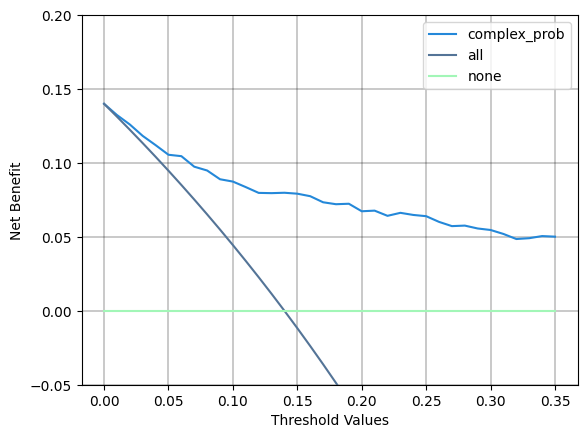

In [27]:
from dcurves import dca, plot_graphs

dca_multi_df = \
    dca(data=df_cancer_dx,
        outcome='cancer',
        modelnames=['complex_prob'],
        thresholds=np.arange(0,0.36,0.01))

plot_graphs(plot_df=dca_multi_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit')


Important in this graph:

- The biopsy-no-one option (`none`) always shows a net benefit of 0: you never make a mistake, but you also never detect a cancer patient. No cost, no benefit. 
- The biopsy-everyone option (`all`) shows good net benefit for lower values of $\theta$. This makes sense, as lower $\theta$ values emphasize catching cancer patients. In this range, biopsy-everyone is a better option than biopsy-no-one. Note that this particular curve starts at 0.14, which is exactly the fraction of people in the dataset with cancer. And the everyone and no one lines cross at $\theta$ equals 0.14, again the prevalence of cancer in the dataset. 
- The net benefit of our model is almost always higher, and this represents the option with the clear clinical benefit. Only for really low $\theta$ values the biopsy-everyone option becomes viable, but that would mean a lot of unnecessary biopsies. 
- Plotting $\theta$ versus net benefit for all these options shows a more subtle performance distribution than we could observe with both accuracy and AUC. In terms of AUC, the biopsy-no-one and everyone options where completely useless compared to the model. Now we see that the story is a bit more subtle, in extreme case one might even prefer the everyone option. 

This decision curve can be used in discussions with medical professionals: how much risk are we willing to take? At what percentage risk of cancer do we order a biopsy? This makes the statistical discussion nicely integrated into medical practice. 

# Conclusion
Looking at our three potential metrics, net benefit is clearly the best option in a medical setting where a diagnostic choice needs to be made. It does not have the sensitivity to unbalanced data, and it nicely extends on the strengths of ROC curves and the AUC score. 

# Acknowledgements
*TODO*

# Background information

- https://www.fharrell.com/post/edca/
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/index.html
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/literature.html
    - [Original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2577036/)
- [Paper criticizing smote and such, also criticizing accuracy specifically and mentioning decision curve analysis indirectly](https://academic.oup.com/jamia/article/29/9/1525/6605096)
